# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

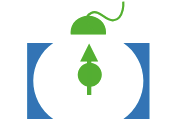

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

initial_params = {
    "POVM": [0.1, -3 * jnp.pi / 2],
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=rho_cav,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="nn",
    goal="purity",
    optimizer="adam",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=10
)

Iteration 0, Loss: 0.884457
Iteration 10, Loss: 0.739370
Iteration 20, Loss: 0.793222
Iteration 30, Loss: 1.169365
Iteration 40, Loss: 0.824181
Iteration 50, Loss: 0.684119
Iteration 60, Loss: 1.089620
Iteration 70, Loss: 0.683050
Iteration 80, Loss: 0.633449
Iteration 90, Loss: 1.119905
Iteration 100, Loss: 0.693458
Iteration 110, Loss: 0.876933
Iteration 120, Loss: 0.754059
Iteration 130, Loss: 0.639201
Iteration 140, Loss: 0.942917
Iteration 150, Loss: 0.892146
Iteration 160, Loss: 0.565086
Iteration 170, Loss: 0.612673
Iteration 180, Loss: 1.251712
Iteration 190, Loss: 0.763867
Iteration 200, Loss: 0.605038
Iteration 210, Loss: 0.835974
Iteration 220, Loss: 0.936382
Iteration 230, Loss: 0.814612
Iteration 240, Loss: 0.740973
Iteration 250, Loss: 0.720874
Iteration 260, Loss: 0.589287
Iteration 270, Loss: 0.544607
Iteration 280, Loss: 0.718376
Iteration 290, Loss: 0.641814
Iteration 300, Loss: 0.704418
Iteration 310, Loss: 0.845550
Iteration 320, Loss: 0.613345
Iteration 330, Loss: 

In [6]:
result

FgResult(optimized_trainable_parameters={'params': {'Dense_0': {'bias': Array([3.3792806, 2.460467 ], dtype=float32), 'kernel': Array([[-0.38436374,  0.5344874 ],
       [-0.37087107,  0.07561443],
       [ 0.1755186 ,  0.32492426],
       [ 0.4564887 , -0.18922646],
       [ 0.18278235,  0.23491211],
       [-0.25871935,  0.428282  ],
       [-0.188159  ,  0.26627854],
       [ 0.41546935, -0.31062645],
       [-0.2421835 , -0.24614263],
       [ 0.03750558,  0.18382886],
       [-0.14159398,  0.16384502],
       [-0.14235327, -0.90108883],
       [ 0.03028303, -0.01833145],
       [ 0.16121323, -0.14615215],
       [ 0.34885067, -0.21160431],
       [-0.07105388,  0.372426  ],
       [ 0.16610506,  0.08696146],
       [ 0.29013085, -0.5284839 ],
       [-0.07548156, -0.27863026],
       [ 0.18019246, -0.26613313],
       [ 0.15890615, -0.37942275],
       [ 0.0543703 ,  0.4267818 ],
       [-0.0162583 ,  0.1778661 ],
       [-0.03047328, -0.4433695 ],
       [-0.09439475,  0.05742752

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 9.97092798e-01+0.j -9.32357527e-03+0.j  7.64119224e-05+0.j ...
   -2.17158942e-04+0.j  7.89419001e-03+0.j -8.64972814e-05+0.j]
  [-9.32357527e-03+0.j  1.22548946e-03+0.j  7.30620500e-05+0.j ...
    4.03918856e-06+0.j  1.28746359e-04+0.j  5.88719984e-07+0.j]
  [ 7.64119224e-05+0.j  7.30620500e-05+0.j  9.96273312e-05+0.j ...
   -1.82043350e-06+0.j -5.94036468e-05+0.j  2.39361291e-07+0.j]
  ...
  [-2.17158942e-04+0.j  4.03918856e-06+0.j -1.82043350e-06+0.j ...
    1.32169624e-07+0.j  2.42057123e-06+0.j  1.01112829e-08+0.j]
  [ 7.89419001e-03+0.j  1.28746359e-04+0.j -5.94036468e-05+0.j ...
    2.42057123e-06+0.j  2.97240800e-04+0.j -1.11528582e-06+0.j]
  [-8.64972814e-05+0.j  5.88719984e-07+0.j  2.39361291e-07+0.j ...
    1.01112829e-08+0.j -1.11528582e-06+0.j  8.69780889e-09+0.j]]

 [[ 1.79916588e-02+0.j  8.17863045e-02+0.j  7.86224243e-02+0.j ...
    5.63047618e-03+0.j  3.57176463e-03+0.j  8.70952811e-03+0.j]
  [ 8.17863045e-02+0.j  3.80651620e-01+0.j  3.59524041e-01+0.j ...
    2.50

In [9]:
# 0.8119213228423314
print(result.final_purity)

0.729336461847927


In [10]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.994720906180023
Purity of state 1: 0.8492779990432466
Purity of state 2: 0.8513998875021348
Purity of state 3: 0.8302792907664766
Purity of state 4: 0.5687334674917135
Purity of state 5: 0.23986304489063678
Purity of state 6: 0.9450506007724471
Purity of state 7: 0.994720906180023
Purity of state 8: 0.4505850481608554
Purity of state 9: 0.5687334674917135


In [11]:
result.returned_params

[[Array([[ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898]], dtype=float64)],
 [Array([[4.70971419, 0.13523885],
         [4.70971419, 0.13523885],
         [4.70971419, 0.13523885],
         [4.70971419, 0.13523885],
         [4.70971419, 0.13523885],
         [2.61662636, 1.89495332],
         [4.70971419, 0.13523885],
         [4.70971419, 0.13523885],
         [4.70971419, 0.13523885],
         [4.70971419, 0.13523885]], dtype=float64)],
 [Array([[ 5.51343646, -0.01704273],
         [ 5.51343646, -0.01704273],
         [ 3.52059801, -0.64329778],
         [ 3.52059801, -0.64329778],
         [ 3.52059801, -0.64329778],
         [ 0.82483856,  2.57565446],
         [ 5.51343646,

In [12]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [13]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [ 0.1        -4.71238898]
purity of rho after time step 0 0.22906440620511653
params for time step 1: [4.70971419 0.13523885]
purity of rho after time step 1 0.42859050777053065
params for time step 2: [ 5.51343646 -0.01704273]
purity of rho after time step 2 0.7246956843230866
params for time step 3: [5.90157695 0.03855725]
purity of rho after time step 3 0.9562146943320481
params for time step 4: [6.06696421 0.05636374]
purity of rho after time step 4 0.994720906180023


In [14]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [15]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 9.97092798e-01+0.j -9.32357527e-03+0.j  7.64119224e-05+0.j
   4.61563944e-04+0.j -6.71354310e-05+0.j -1.36225103e-03+0.j
  -6.46583096e-04+0.j -6.15326654e-04+0.j -2.71554275e-03+0.j
  -9.06907855e-04+0.j  4.11715087e-04+0.j -1.08457337e-04+0.j
   1.09358768e-03+0.j -7.60303261e-04+0.j  7.96172265e-05+0.j
  -2.51949060e-04+0.j  2.57779460e-03+0.j  5.27986686e-05+0.j
   7.13994853e-05+0.j -5.02336888e-04+0.j  3.80552580e-04+0.j
  -2.10937269e-04+0.j -2.51597803e-04+0.j -2.07880614e-04+0.j
  -7.36040392e-03+0.j  2.64723672e-04+0.j  6.19286764e-03+0.j
  -2.17158942e-04+0.j  7.89419001e-03+0.j -8.64972814e-05+0.j]
 [-9.32357527e-03+0.j  1.22548946e-03+0.j  7.30620500e-05+0.j
   6.52073062e-06+0.j -1.56367537e-05+0.j  5.46680863e-06+0.j
   1.30598173e-05+0.j  5.22229185e-06+0.j -2.36175103e-05+0.j
   1.48904142e-06+0.j  1.51853348e-05+0.j  1.85335454e-06+0.j
   2.26084179e-05+0.j  4.09175335e-06+0.j  1.63622979e-05+0.j
   4.62452319e-06+0.j  2

In [16]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 9.97092798e-01+0.j -9.32357527e-03+0.j  7.64119224e-05+0.j ...
   -2.17158942e-04+0.j  7.89419001e-03+0.j -8.64972814e-05+0.j]
  [-9.32357527e-03+0.j  1.22548946e-03+0.j  7.30620500e-05+0.j ...
    4.03918856e-06+0.j  1.28746359e-04+0.j  5.88719984e-07+0.j]
  [ 7.64119224e-05+0.j  7.30620500e-05+0.j  9.96273312e-05+0.j ...
   -1.82043350e-06+0.j -5.94036468e-05+0.j  2.39361291e-07+0.j]
  ...
  [-2.17158942e-04+0.j  4.03918856e-06+0.j -1.82043350e-06+0.j ...
    1.32169624e-07+0.j  2.42057123e-06+0.j  1.01112829e-08+0.j]
  [ 7.89419001e-03+0.j  1.28746359e-04+0.j -5.94036468e-05+0.j ...
    2.42057123e-06+0.j  2.97240800e-04+0.j -1.11528582e-06+0.j]
  [-8.64972814e-05+0.j  5.88719984e-07+0.j  2.39361291e-07+0.j ...
    1.01112829e-08+0.j -1.11528582e-06+0.j  8.69780889e-09+0.j]]

 [[ 1.79916588e-02+0.j  8.17863045e-02+0.j  7.86224243e-02+0.j ...
    5.63047618e-03+0.j  3.57176463e-03+0.j  8.70952811e-03+0.j]
  [ 8.17863045e-02+0.j  3.80651620e-01+0.j  3.5952

In [17]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [18]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [19]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [20]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [21]:
batch_size = 2

In [22]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [23]:
rho_final_batched.shape

(2, 30, 30)

In [24]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [25]:
rng_keys[0].shape

(2,)

In [26]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]
